# Ising model

The aim of this exercise is to simulate the model with Markov Chains Montecarlo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 2-d standard Ising model

In the 2-d standard Ising model, the nodes are arranged in a two dimensional lattice, let's say of size $L$. Therefore, the total number of spins is $N=L^2$. Each spin is identified by its coordinates $(x,y)$, where $x, y \in \lbrace 1,2, \ldots, L\rbrace$.

The interactions occur only between nearest neighbours of the lattice with a constant coupling coefficient $J$: the spin at $(x,y)$ interact with $(x+1,y)$, $(x-1,y)$, $(x,y+1)$, $(x,y-1)$. We also impose periodic boundary conditions, such that the spin at the boundary $(L, y)$ interact with the spin at the opposite boundary $(0,y)$ (the same is true for the spins at $y=L$ and $y=0$).
As a consequence, the Hamiltonian of the system has this shape:

\begin{equation}
\mathcal{H}\left(\vec{\sigma}\right) = - \sum_{x,y = 1}^{L} \sigma_{x,y} \left[ \frac{J}{2} \left( \sigma_{x+1,y} + \sigma_{x-1,y} + \sigma_{x,y+1} + \sigma_{x,y-1} \right) + h \right]
\end{equation}

where the spins are binary variables, $\sigma_{x,y} \in \lbrace -1,1 \rbrace$,and the boundary conditions say that $x,y=L+1 = 1$ and $x,y=L=0$.

## Metropolis algorithm for Ising

The idea of Markov Chain Montecarlo is to jump around among the states of my systems (without enumerating all of them) by choosing the transition probabilities in such a way that the states that I get after each jump are samples that follow the probability distribution of the model.
In such a way only a very small subset of the states are visited, however, this subset is large enough to be used for reliable computation of macroscopic observables.


### 1 - Pseudocode for one step of the Metropolis algorithm for the Ising Model:

The following pseudocode provides a transition from one state (or configuration of spins) of the Ising model, $\vec{\sigma}$ to another, in a way that the detail balance of the resulting Markov Chain (where the states are all the spin configurations) is satisfied.
This is one step of the so-called Metropolis algorithm:

`Metropolis_step`($\vec{\sigma}$, $\beta$, $J$, $h$):
> - Given the configuration $\vec{\sigma}$, choose one of the $N$ spins at random, say $(\bar{x}, \bar{y})$, and consider a new configuration $\vec{\sigma}'$ such that $\sigma'_{\bar{x}, \bar{y}} = -\sigma_{\bar{x}, \bar{y}}$.
> - Compute the energy difference between the two states:
> \begin{equation}
\Delta E = \mathcal{H}\left( \vec{\sigma}' \right) - \mathcal{H}\left( \vec{\sigma} \right) = 2 \sigma_{\bar{x}, \bar{y}} \left( J \sum_{x,y \in B(\bar{x}, \bar{y})} \sigma_{{x}, {y}} + h\right)
\end{equation}
> where $B(\bar{x}, \bar{y})$ are the neighbours of $(\bar{x}, \bar{y})$, four in this standard 2-d model.
> - If the energy of the new state is less than the previous one,  $\Delta E \le 0$, accept the new change (i.e. overwrite $\sigma$: $\vec{\sigma} \rightarrow \vec{\sigma}'$), if not, accept the new change with probability $p = \exp[-\beta \Delta E]$.
> - Return $\vec{\sigma}$ 

Write the function `Metropolis_step`($\vec{\sigma}$, $\beta$, $J$, $h$).

In [2]:
def metropolis_step(state, beta, J, h):
  """
  This performs a single metropolis move by flipping one spin of the state,
  Compute the energy difference between the old and new state, and accepting
  or rejecting the new configuration
  """
  lx, ly = state.shape[0], state.shape[1]

  # Choosing the spin to flip
  x, y = np.random.randint(0, lx), np.random.randint(0, ly) 

  # Computing the energy difference 
  aux_dE = state[(x, (y+1)%ly)] + state[(x, (y-1)%ly)] + state[((x+1)%lx, y)] + state[((x-1)%lx, y)]
  delta_E = 2 * state[x, y] * ( J * aux_dE + h )

  # Accepting or rejecting the flipped spin according to the Metropolis rule
  if delta_E <= 0 or np.random.rand() < np.exp(-beta * delta_E):
    state[x,y] *= -1

  return state

Before writing down the whole algorithm in its full glory, let's analyse how this chain works.
We will focus on some potential problems that one should take int account in generating samples with Metropolis.
This problems are in  general true for all Markov Chain Montecarlo methods, and are **correlation** bewteen samples, and the transient time for **equilibration** of the chain.

### Visualize some configurations of spins varing the temperature and the simulation time 

Let's first visualize how a state of the Ising model changes by iterating the Markov Chain.

Start from a state generated at random (try $L=30$) and iterate the chain using `Metropolis_step`($\vec{\sigma}$, $\beta$, $J$, $h$). 

Draw the state at different temperatures to see what changes.
Try for example, T = 0.5, 2, 10.
Do you see the different behaviors of the three temperatures? Which change from a complete random/disordered state (at high temperature) to a completely coherent one (low temperature).

In [3]:
from copy import copy

# Parameters
L = 50
J = 1
h = 0.1

# Which temperature to test
temperatures = [10, 2.25, 1] 

# At which step of the chain the configuration is stored
times_to_store = np.array([1, 10**3, 10**4, 2*10**5]) 

states = []
for T in temperatures:

  # Initial state
  s = np.random.randint(0,2, (L,L))*2-1

  # Time steps of the chain
  for t in range(times_to_store[-1]+1):

    # One step of the chain
    s = metropolis_step(s, 1/T, J, h)

    # If the time is in the list of times to store, the configuration is copied
    # Note the hard copy.
    if t in times_to_store:
      states.append(copy(s))

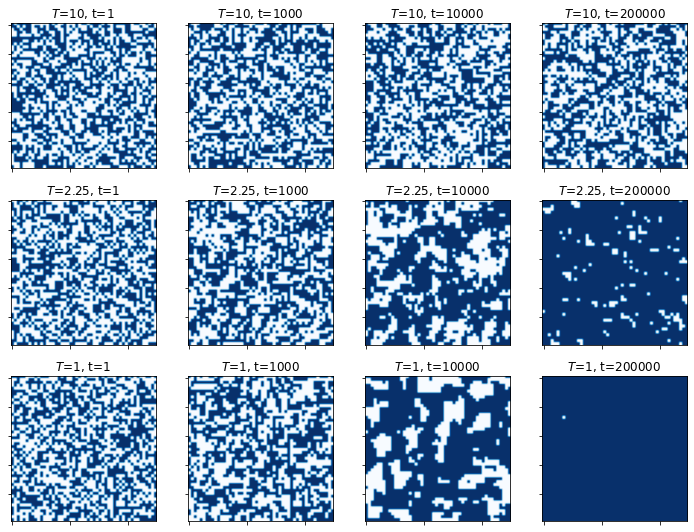

In [4]:
# The size of the figure is specified with figsize inside plt.figure
plt.figure(figsize=(2.5*len(times_to_store), 2.5*len(temperatures)))

plt_counter = 0
# Iteration over all the temperatures and snapshots
for i in range(len(temperatures)):
  for j in range(len(times_to_store)):

    # Defining the subplot: N. rows, N. cols, number of plot
    plt.subplot(len(temperatures), len(times_to_store), plt_counter+1)
    # Title
    plt.title(r"$T$={}, t={}".format(temperatures[i], times_to_store[j]))
    # Remuving the tics
    plt.tick_params(axis='both', labelbottom=False, labelleft=False)
    # Plotting the matrix
    plt.imshow(states[plt_counter], cmap='Blues')
    plt_counter += 1
    
plt.tight_layout()

From the snapshot that you plotted you can see that the model needs some time to move from the random initial confiuration to the "equilibrium" one.
The samples that we want to generate through the chain should be only taken at equilibrium, and therefore we want to discard what happened before (the transient time).

This is a typical "problem" of MCMC, where, usually, one discards the initials steps to wait for the equilibration. This is sometimes called **burn-in period**. 

A possible way to identify the right time after which we can considerate the chain at equilibrium is to plot the trajectory of some observable, and see when it becomes stationary.
Guess what observable we choose? Of course our dear magnetization.

### 2 - Plot the average magnetization as a function of the simulation time (to find a good burn-in time)

Compute the magnetization of several parallel trajecotries as a function of the simulation time and compute their average. 

Consider the magnetization as it is, but the **absolute value** of it.
This because the system is completely symmetric by flipping all the spins (the energy is the same), however the magnetization changes sign. Therefore, for each configuration having a given magnetization, you have a flipped configuration (with same probability) having an opposite magnetization (if $h=0$). As a consequence the average magnetization is always zero, but the average of its absolute value not.

Try to see when these trajectories reach a stationary value for a fixed lattice size (try $L=15$), and for each size try different temperatures in the three different regimes that we saw in the snapshots.

What is a good burn-in time?

In [5]:
def abs_magnetization(state):
  """
  This returns the absolute value of the magnetization of a given configuration/
  state as a 2d array.
  """
  lx, ly = state.shape
  return abs(state.sum()) / lx / ly


def magnet_average_trajectory(L, beta, J, h, max_time, n_realizations):
  """
  This computes the trajectory from 0 to "max_time" steps of the average 
  magnetization over "n_realizations" for the standard Ising model having side
  "L", "beta", "J" and "h".
  """
  average_traj = np.zeros(max_time)
  for _ in range(n_realizations):
    traj = np.array([])
    state = np.random.randint(0,2, (L,L))*2-1
    for t in range(max_time):
      state = metropolis_step(state, beta, J, h)
      traj = np.append(traj, abs_magnetization(state))
    average_traj += traj / n_realizations
  return average_traj

In [6]:
L = 24
J = 1
h = 0.5
temperatures = [1, 2, 4]
max_time = 10000

trajs = []
for T in temperatures:
  trajs.append(magnet_average_trajectory(L, 1/T, J, h, max_time, 20))
  print(T, 'done')

1 done
2 done
4 done


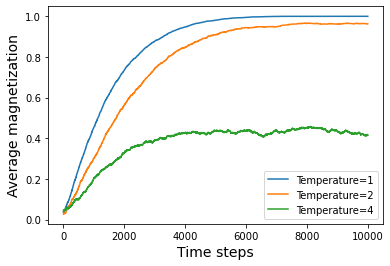

In [7]:
plt.xlabel('Time steps', fontsize=14)
plt.ylabel('Average magnetization', fontsize=14)
for i in range(len(temperatures)):
  plt.plot(trajs[i], label="Temperature={}".format(temperatures[i]))
plt.legend()
#plt.savefig(path + 'Magnetization_trajs_L={}.png'.format(L))

1 done
2 done
4 done


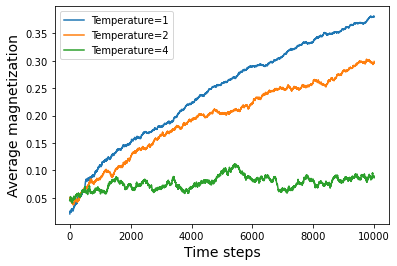

In [8]:
L = 24
J = 1
h = 0.05
temperatures = [1, 2, 4]
max_time = 10000

trajs = []
for T in temperatures:
  trajs.append(magnet_average_trajectory(L, 1/T, J, h, max_time, 20))
  print(T, 'done')
plt.xlabel('Time steps', fontsize=14)
plt.ylabel('Average magnetization', fontsize=14)
for i in range(len(temperatures)):
  plt.plot(trajs[i], label="Temperature={}".format(temperatures[i]))
plt.legend()

### 4 - Find the correlation length of the chain

In Montecarlo methods the samples must be independent.
This is not true in general for all the samples that Metropolis algorithm generates.

The trick to get independent samples is to discard a certain number of samples before considering the next one which will be used to compute the sample average. The question is: how many samples I have to discard?

The temporal autocorrelation function (https://en.wikipedia.org/wiki/Autocorrelation) for the magnetization can give us the answer:

$$
\rho(t_1, t_2) = \frac{\langle M_{t_1} M_{t_2} \rangle - \langle M_{t_1}\rangle \langle M_{t_2} \rangle  }{\text{std}(M_{t_1})\text{std}(M_{t_2})}
$$

Note that if the two variables are independent $\rho = 0$ since the average of their product is the product of their averages. On the contrary, for complete correlation, i.e. the two variables are the same, $\rho = 1$.

Here we want to study the autocorrelation of the magnetization by choosing $t_1$ larger than the burn-in time (we want to be in the stationary state), and seeing for which $t_2^*$ the correlation disapperars. $t_2^*-t_1$ will give us the number of steps to wait is such a way that two consecutive samples are uncorrelated.

In [ ]:
def magnet_autocorrelation(L, beta, J, h, burn_in_time, max_corr_time, n_realizations):
  """
  This computes the temporal autocorrelation from "burn_in_time" for "max_corr_time" 
  of the average magnetization over "n_realizations" for the standard Ising model 
  having side "L", "beta", "J" and "h".
  """
  # Init the magnetiz product, the first and the second moments
  prod = np.zeros(max_corr_time)
  average_at_start = 0
  average_at_next = np.zeros(max_corr_time)
  sec_moment_at_start = 0
  sec_moment_at_next = np.zeros(max_corr_time)
  
  for _ in range(n_realizations):

    # Equilibration
    state = np.random.randint(0,2, (L,L))*2-1
    for _ in range(burn_in_time):
      state = metropolis_step(state, beta, J, h)

    # The start valu of the magetization is computed after the burn-in period.
    start_magnet = abs_magnetization(state)
    average_at_start += start_magnet / n_realizations
    sec_moment_at_start += start_magnet * start_magnet / n_realizations

    # Storing the value of all the magnetizations after the burn-in
    traj = np.array([])
    for _ in range(burn_in_time, burn_in_time + max_corr_time):
      state = metropolis_step(state, beta, J, h)
      traj = np.append(traj, abs_magnetization(state))

    # Computing the statistical variables 
    prod += start_magnet * traj / n_realizations
    average_at_next += traj / n_realizations
    sec_moment_at_next += traj*traj / n_realizations

  std_start = np.sqrt(sec_moment_at_start - average_at_start**2)
  std_next = np.sqrt(sec_moment_at_next - average_at_next**2)
  return (prod - average_at_next*average_at_start) / std_start / std_next

In [ ]:
L = 24
J = 1
h = 0.5
temperatures = [2,4]
burn_in_time = 50000
max_time = 10*L*L

autocorr_trajs = []
for T in temperatures:
  autocorr_trajs.append(magnet_autocorrelation(L, 1/T, J, h, burn_in_time, max_time, 100))
  print(T, 'done')

2 done
4 done


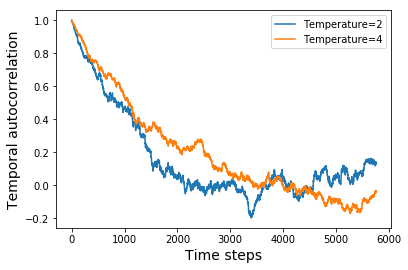

In [ ]:
plt.xlabel('Time steps', fontsize=14)
plt.ylabel('Temporal autocorrelation', fontsize=14)
for i in range(len(temperatures)):
  plt.plot(autocorr_trajs[i], label="Temperature={}".format(temperatures[i]))
plt.legend()
plt.savefig(path + 'Magnetization_autocorrelation_L={}.png'.format(L))

From this plot we can see the typical correlation length.

### 5 - Phase transition

Now we have all the ingredients to simulate the Ising model through Metropolis. The aim of this simulation is to estimate the average (absolute) magnetization using the sample average:
$$
\langle M \rangle = \frac{1}{N} \sum_{k=1}^N M(\vec{\sigma})
$$
where the samples $\vec{\sigma}$ are generated through the Metropolis algorithm which starts to sample after a given burn-in period and, to remove correlations, discards several state of the chain.

A pseudocode can be:
> - Init the average magnetization $\langle M \rangle=0$.
> - Generate a random initial state $\sigma$
> - Iterate the chain $i = 1, \ldots, t_{\text{burn-in}}$ (**equilibration**):
>> - Updated the states without updating the magnetization $\sigma$ = `metropolis_step`($\sigma$, $\beta$, J, h)
> - Interate over the number of samples $i = 1, \ldots, N$:
>> - Iterate the chain $i = 1, \ldots, t_{\text{corr}}$ (**independence**):
>>> - Updated the states without updating the magnetization $\sigma$ = `metropolis_step`($\sigma$, $\beta$, J, h)
>> - Compute the magnetization at the current $\vec{\sigma}$ and uptate $\langle M \rangle = \langle M \rangle + M(\vec{\sigma}) / N$
>- Return $\langle M \rangle$

Try to implement this code into a function that given the arguments L, beta, J, h, n_samples, t_burn_in, t_correlation, returns the average magnetization.

In [5]:
def metropolis_ising(L, beta, J, h, n_samples, t_burn_in, t_correlation):
  """
  This runs a MCMC simulation of a 2-d standard Ising model of size "L", 
  having paramenter "beta", a given coupling constant "J" and external field
  "h".
  The simulation is runned for "max_time" steps and returns the average energy
  and the average of all the observables contained in the "observables" list.
  The "states_to_return_at_time" argument is a list of times at which the 
  computed state is returned. An empty list will return an emply list of states.
  """

  magnet = np.array([])
  generated_samples = 0
  state = np.random.randint(0,2,(L,L))*2-1 # First state generated at random

  # Burn-in
  for _ in range(t_burn_in):
    state = metropolis_step(state, beta, J, h)

  magnet = np.append(magnet, abs_magnetization(state))
  generated_samples += 1

  while generated_samples <= n_samples:

    # Discarding correlated samples
    for _ in range(t_correlation):
      state = metropolis_step(state, beta, J, h)

    magnet = np.append(magnet, abs_magnetization(state))
    generated_samples += 1

  return magnet.mean()

By plotting the average magnetization (order parameter) for different temperatures (control parameter) you can see the phase transition (actually a smooth version of it, since the lattice is not infinite).

Here compute for different tempereatures the average magnetization and plot it versus the temperature.

In [6]:
import sys

def magnetiz_curve(L, J, h, temperatures, n_samples, t_burn_in, t_correlation):
  """
  This function compute the average magnetization for different temperatures.
  """
  magnet = np.array([])
  for t in temperatures:
    magnet = np.append(magnet, metropolis_ising(L, 1/t, J, h, n_samples, t_burn_in, t_correlation))
    sys.stdout.write("\rTemperature: {:.2f}/{:.2f} done, magnetization: {:.2f}".format(t, temperatures[-1], magnet[-1]))
    sys.stdout.flush()
  return magnet

In [22]:
#Suggested parameters
L = 24
J = 0.5
h = 0.1
n_samples = 20
t_burn_in = 30000
t_correlation = 2000
temperatures = np.linspace(1, 5, 50)

In [23]:
magnetizations = magnetiz_curve(L, J, h, temperatures, n_samples, t_burn_in, t_correlation)

Temperature: 5.00/5.00 done, magnetization: 0.04

No handles with labels found to put in legend.


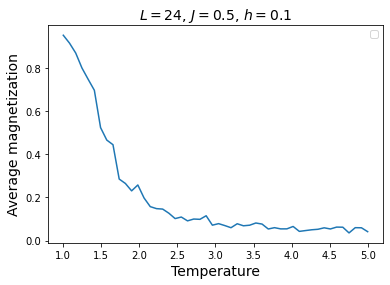

In [24]:
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Average magnetization', fontsize=14)
plt.title(r'$L={}$, $J={}$, $h={}$'.format(L, J, h, t_burn_in), fontsize=14)
plt.plot(temperatures, magnetizations)

plt.legend()